In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import hilbert
from time import time 

## Creating Signal - e.g. Alpha (Carrier Freq 10 hz)

Sets up a matrix of three signals each with the same frequency components, but shifted by a few milliseconds/seconds.

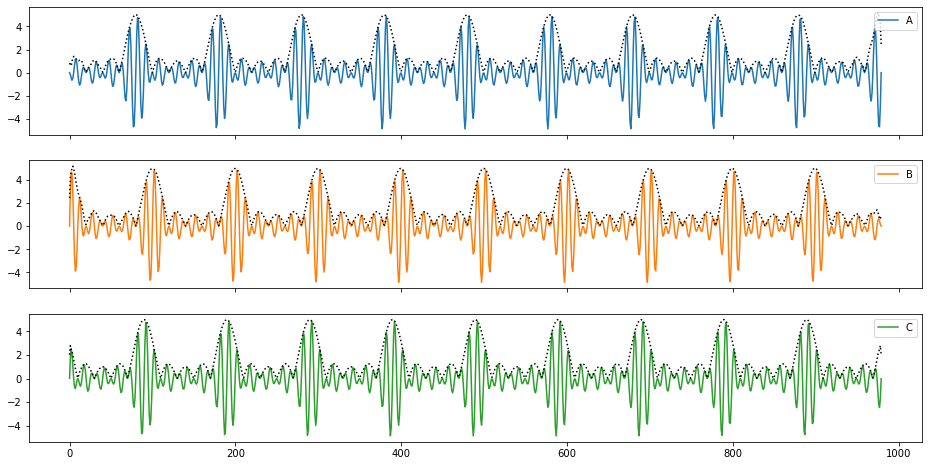

In [2]:
# Set up signal parameters
timepoints = 1000 # number of timepoints
totaltime = 10 # in seconds
fsample = timepoints/totaltime
carrier_freq = 10 # in hz
shift = 0.2 # in seconds

# Define signal as 4 sine waves with frequencies +/- 2 hz of the carrier freq
t = np.linspace(0,totaltime,timepoints)

s = np.zeros(timepoints)
for i in np.arange(-2,3,1):   
    s += np.sin((carrier_freq+i)*t*2*np.pi)

# shifting signal in range of seconds
shift = int(shift*fsample)
a = s[shift:]
b = s[:-shift]
c = s[shift//2:-shift//2]

signals = np.stack([a,b,c])

# calculate analytic signal and envelope
analytic_signals = hilbert(signals, axis=-1)
envelopes = np.abs(analytic_signals)

# Plot 
colors = ['tab:blue', 'tab:orange', 'tab:green']
names = ['A','B','C']
fig, axes = plt.subplots(3,1,figsize=(16,8), sharex=True)
for n,ax in enumerate(axes.flat): 
    ax.plot(signals[n,:], color=colors[n],label=names[n])
    ax.plot(envelopes[n,:], ':k')
    ax.legend(loc='upper right')

# Define Functions to calculate V and CCD

## Calculate V


Following Deco et. al 2017:
1. Get phase of all signal envelopes
2. Calculate the phase difference between all pairs of signals
3. Take the cosine of the phase difference

In [3]:
# define function to calculate V
def calc_v(s):
    #calculate phase of envelope
    analytic = hilbert(s, axis=-1)
    phases = np.angle(analytic)

    #Calculate phase differences 
    diff_phases = [np.abs(phase1-phase2) for phase1 in phases for phase2 in phases]
    diff_phases = np.stack(diff_phases)

    # V is the cosine of the absolute phase differences
    v = np.cos(diff_phases)
    return v, phases, diff_phases

### Plot phases, phase differences and V of two example signals

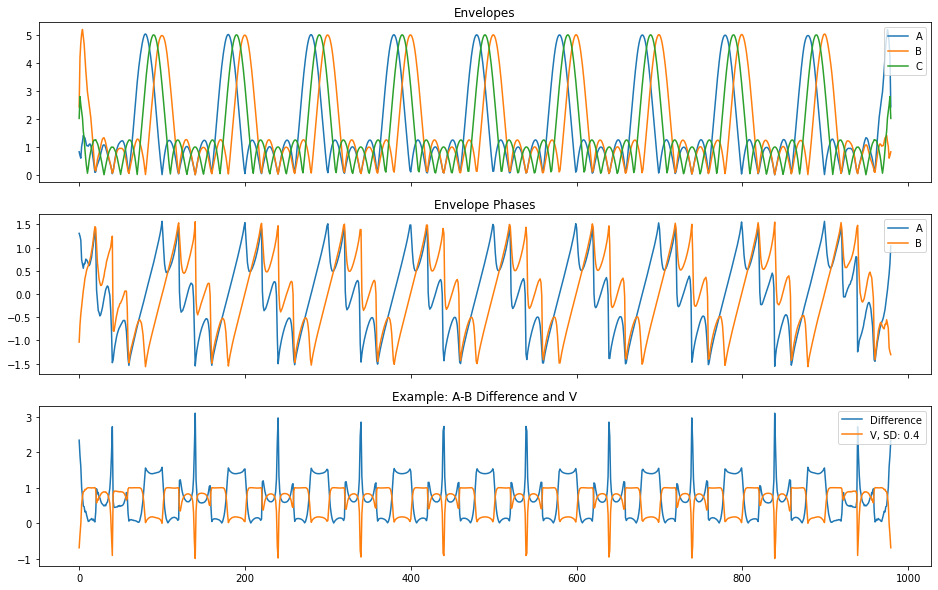

In [4]:
# Apply v function on envelopes
v, phases, diff_phases = calc_v(envelopes)

# Plot 
fig, axes = plt.subplots(3,1, figsize=(16,10), sharex=True)
axes[0].set_title('Envelopes')
for n, envelope in enumerate(envelopes): 
    axes[0].plot(envelope, label=names[n])
    axes[0].legend(loc='upper right')


axes[1].set_title('Envelope Phases')
for n, phase in enumerate(phases[:2,:]): 
    axes[1].plot(phase, label=names[n])
    axes[1].legend(loc='upper right')

    
axes[2].set_title('Example: A-B Difference and V')
axes[2].plot(diff_phases[1,:], label='Difference')
axes[2].plot(v[1,:], label=f'V, SD: {np.round(np.std(v[1,:]),2)}')
axes[2].legend(loc='upper right')

## Calculate CCD 

The CCD is a matrix of cosine similarities (i.e. 1-cosine.disimilarity) between all pairs of V(t) vectors. 
The cosine similarity is equal to the normalized vector product, i.e. one can calculate the cosine similarity using scipy.linalg.norm.

In [5]:
# Calculate CCD using scipy.spatial.distance.cosine
def ccd_slow(v):
    from scipy.spatial.distance import cosine
    start = time()
    t = v.shape[1]
    ccd = np.zeros((t, t))
    for i in range(t):
        for j in range(i, t): 
            c = 1 - cosine(v[:,i], v[:,j])
            ccd[i,j] = ccd[j,i] = c  
    print('Time Slow CCD: ',time()-start)
    return ccd

# Calculate CCD using vector norm
def ccd_fast(v):
    from scipy.linalg import norm
    start = time()
    v_norm = norm(v, axis=0)
    ccd = np.matmul(v.T, v)
    ccd /= v_norm 
    ccd = ccd.T / v_norm 
    print('Time Fast CCD: ',time()-start)
    return ccd 

### Plot CCD matrix, check if slow and fast CCD functions are equal

Time Slow CCD:  37.686049938201904
Time Fast CCD:  0.015637874603271484
Slow and fast CCD are equal:  True


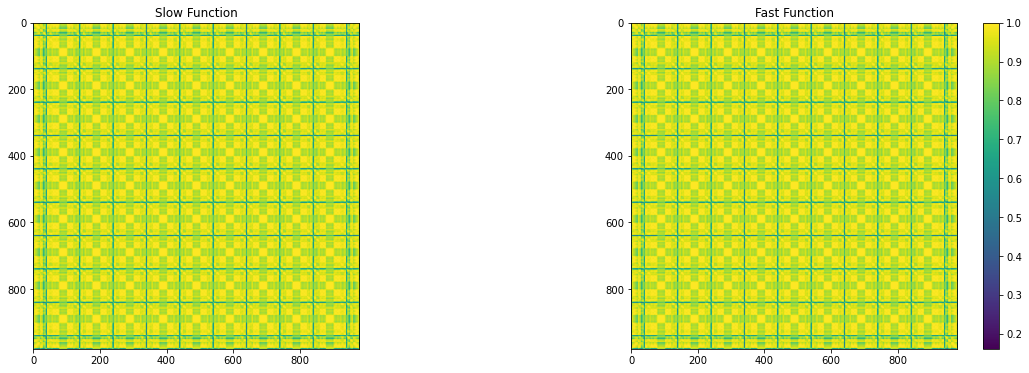

In [6]:
ccd1 = ccd_slow(v)
ccd2 = ccd_fast(v)

# Check if fast and slow produce the same matrix
print('Slow and fast CCD are equal: ', np.all(np.isclose(ccd1,ccd2)))

# Plot 
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes[0].imshow(ccd1); axes[0].set_title('Slow Function')
cax = axes[1].imshow(ccd2); axes[1].set_title('Fast Function')
fig.colorbar(cax)

# LowPass filter Envelope before calculating CCD 

Setting up low-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 165 samples (1.650 sec)

Time Fast CCD:  0.01562666893005371


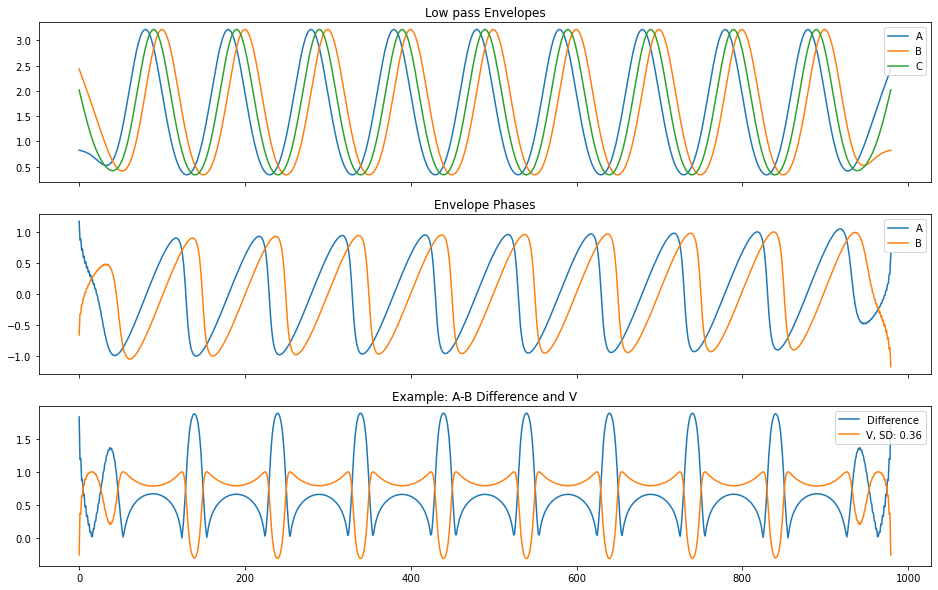

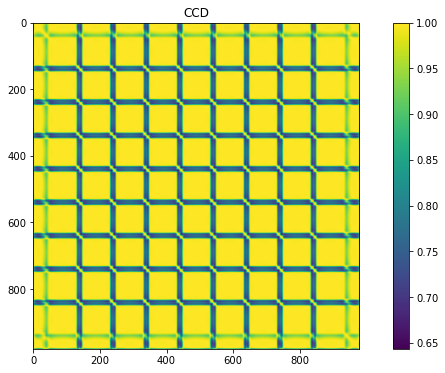

In [7]:
from mne.filter import filter_data as filter
lowpassfreq = 0.5

# Lowpass filter envelope
low_envelopes = filter(envelopes, fsample, 0, lowpassfreq)

#calculate phase of envelope
v, phases, diff_phases = calc_v(low_envelopes)

# Plot 
fig, axes = plt.subplots(3,1, figsize=(16,10), sharex=True)
axes[0].set_title('Low pass Envelopes')
for n, envelope in enumerate(low_envelopes): 
    axes[0].plot(envelope, label=names[n])
    axes[0].legend(loc='upper right')


axes[1].set_title('Envelope Phases')
for n, phase in enumerate(phases[:2,:]): 
    axes[1].plot(phase, label=names[n])
    axes[1].legend(loc='upper right')

    
axes[2].set_title('Example: A-B Difference and V')
axes[2].plot(diff_phases[1,:], label='Difference')
axes[2].plot(v[1,:], label=f'V, SD: {np.round(np.std(v[1,:]),2)}')
axes[2].legend(loc='upper right')

# Calculate ccd matrix
ccd = ccd_fast(v)

# Plot 
fig, axes = plt.subplots(figsize=(12,6))
cax = axes.imshow(ccd); axes.set_title('CCD')
fig.colorbar(cax)

# Calculate CCD on bandpass Signal

Time Fast CCD:  0.015631675720214844


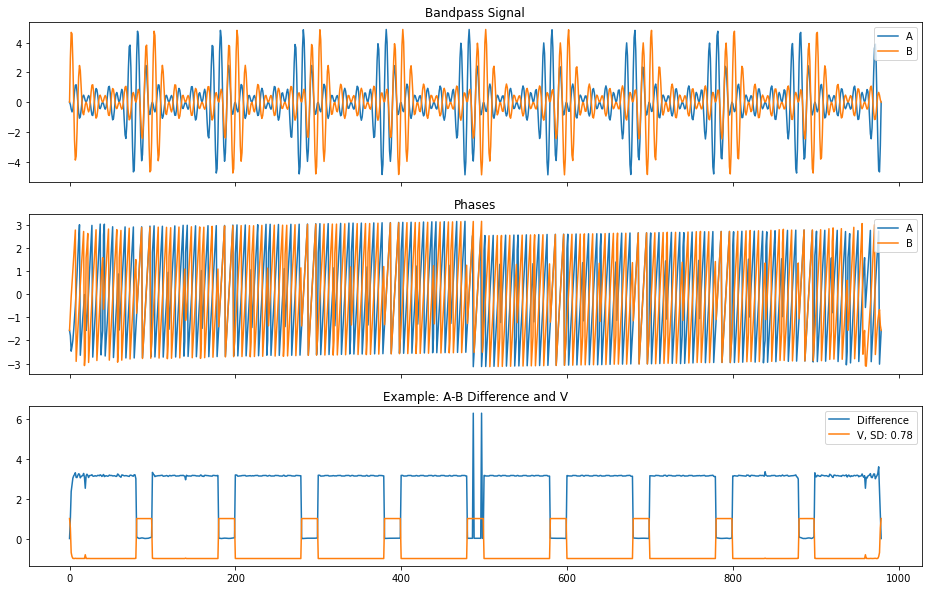

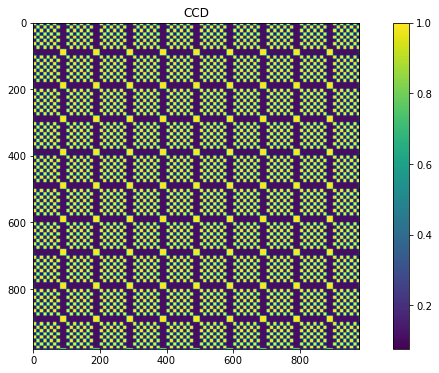

In [8]:
#calculate phase of envelope
v, phases, diff_phases = calc_v(signals)

# Calculate ccd matrix
ccd = ccd_fast(v)

# Plot 
fig, axes = plt.subplots(3,1, figsize=(16,10), sharex=True)
axes[0].set_title('Bandpass Signal')
for n, signal in enumerate(signals[:2,:]): 
    axes[0].plot(signal, label=names[n])
    axes[0].legend(loc='upper right')


axes[1].set_title('Phases')
for n, phase in enumerate(phases[:2,:]): 
    axes[1].plot(phase, label=names[n])
    axes[1].legend(loc='upper right')

    
axes[2].set_title('Example: A-B Difference and V')
axes[2].plot(diff_phases[1,:], label='Difference')
axes[2].plot(v[1,:], label=f'V, SD: {np.round(np.std(v[1,:]),2)}')
axes[2].legend(loc='upper right')

# Plot CCD 
fig, axes = plt.subplots(figsize=(12,6))
cax = axes.imshow(ccd); axes.set_title('CCD')
fig.colorbar(cax)